2) Импорт необходимых библиотек

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 5]

Загрузка данных student-por.csv

In [12]:
print("СТУДЕНЧЕСКИЕ ДАННЫЕ (student-por.csv):")
try:
    df_student_single = pd.read_csv('../student-por.csv', sep=';')
    print("✓ Успешно загружено как одна колонка")
    print(f"  Исходный размер: {df_student_single.shape}")
    
    if df_student_single.shape[1] == 1:
        first_col = df_student_single.columns[0]
        print(f"  Единственная колонка: '{first_col}'")
        
        print("  Разделяем данные по запятой...")
        split_data = df_student_single[first_col].str.split(',', expand=True)
        print(f"  После разделения: {split_data.shape}")
        
        correct_columns = [
            'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 
            'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 
            'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 
            'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 
            'G1', 'G2', 'G3'
        ]
        
        if split_data.shape[1] == len(correct_columns):
            split_data.columns = correct_columns
            df_student = split_data
            print("✓ Успешно присвоены названия колонок")
        else:
            print(f"⚠ Количество колонок не совпадает: ожидалось {len(correct_columns)}, получено {split_data.shape[1]}")
            split_data.columns = correct_columns[:split_data.shape[1]]
            df_student = split_data
            print("✓ Использованы доступные названия колонок")
        
        print("  Преобразуем числовые колонки...")
        numeric_columns = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                          'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
                          'G1', 'G2', 'G3']
        
        for col in numeric_columns:
            if col in df_student.columns:
                df_student[col] = pd.to_numeric(df_student[col], errors='coerce')
                print(f"    ✓ '{col}' преобразована в числовой формат")
        
        print(f"✓ Итоговый размер: {df_student.shape}")
        print(f"✓ Колонки: {len(df_student.columns)}")
        print("\nПервые 3 строки после разделения:")
        print(df_student.head(3))
        
    else:
        df_student = df_student_single
        print("✓ Данные уже разделены")
        
except Exception as e:
    print(f"✗ Ошибка: {e}")
    df_student = None

СТУДЕНЧЕСКИЕ ДАННЫЕ (student-por.csv):
✓ Успешно загружено как одна колонка
  Исходный размер: (649, 1)
  Единственная колонка: 'school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3'
  Разделяем данные по запятой...
  После разделения: (649, 33)
✓ Успешно присвоены названия колонок
  Преобразуем числовые колонки...
    ✓ 'age' преобразована в числовой формат
    ✓ 'Medu' преобразована в числовой формат
    ✓ 'Fedu' преобразована в числовой формат
    ✓ 'traveltime' преобразована в числовой формат
    ✓ 'studytime' преобразована в числовой формат
    ✓ 'failures' преобразована в числовой формат
    ✓ 'famrel' преобразована в числовой формат
    ✓ 'freetime' преобразована в числовой формат
    ✓ 'goout' преобразована в числовой формат
    ✓ 'Dalc' преобразована в числовой формат
    ✓ 'Walc' преобразована в числовой

Загрузка данных house.csv

In [13]:
try:
    df_house = pd.read_csv('../house.csv')
    print("✓ Успешно загружено")
    print(f"  Размер: {df_house.shape}")
    print(f"  Колонки: {len(df_house.columns)}")
except Exception as e:
    print(f"✗ Ошибка: {e}")
    df_house = None

✓ Успешно загружено
  Размер: (4746, 12)
  Колонки: 12


Функции предобработки данных для классификации (студенческие данные)

In [14]:
def preprocess_student_classification(df):
    """Предобработка студенческих данных для классификации"""
    print("\n" + "="*50)
    print("ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)")
    print("="*50)
    
    if df is None:
        print("❌ DataFrame пустой")
        return None, None, None
    
    df_clean = df.copy()
    
    print("Доступные колонки:")
    for i, col in enumerate(df_clean.columns):
        print(f"  {i+1:2d}. '{col}' (тип: {df_clean[col].dtype})")
    
    if 'G3' not in df_clean.columns:
        print("❌ Колонка 'G3' не найдена!")
        print("   Доступные колонки:", list(df_clean.columns))
        return None, None, None
    
    print(f"✓ Найдена целевая переменная: 'G3'")
    print(f"  Диапазон значений: {df_clean['G3'].min()} - {df_clean['G3'].max()}")
    
    df_clean['academic_success'] = (df_clean['G3'] >= 10).astype(int)
    success_rate = df_clean['academic_success'].mean() * 100
    print(f"✓ Создана целевая переменная 'academic_success'")
    print(f"  Процент успевающих студентов: {success_rate:.1f}%")
    
    numeric_features = []
    possible_numeric = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
    
    print("\nПоиск числовых признаков:")
    for feature in possible_numeric:
        if feature in df_clean.columns:
            if df_clean[feature].dtype == 'object':
                df_clean[feature] = pd.to_numeric(df_clean[feature], errors='coerce')
            numeric_features.append(feature)
            print(f"  ✓ '{feature}' найден")
        else:
            print(f"  ✗ '{feature}' не найден")
    
    categorical_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 
                           'Fjob', 'reason', 'guardian']
    
    features = numeric_features.copy()
    le = LabelEncoder()
    
    print("\nПоиск и кодирование категориальных признаков:")
    for feature in categorical_features:
        if feature in df_clean.columns:
            try:
                df_clean[f'{feature}_encoded'] = le.fit_transform(df_clean[feature].astype(str))
                features.append(f'{feature}_encoded')
                print(f"  ✓ '{feature}' закодирован")
            except Exception as e:
                print(f"  ✗ '{feature}' ошибка кодирования: {e}")
        else:
            print(f"  ✗ '{feature}' не найден")
    
    initial_count = len(df_clean)
    df_clean = df_clean.dropna(subset=features + ['academic_success'])
    final_count = len(df_clean)
    
    print(f"\n✓ Очистка данных: {initial_count} → {final_count} строк")
    print(f"✓ Используется {len(features)} признаков")
    
    if not features or df_clean.empty:
        print("❌ Недостаточно данных для анализа")
        return None, None, None
    
    X = df_clean[features]
    y = df_clean['academic_success']
    
    print(f"✓ Итоговый набор данных: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"  Баланс классов: {np.bincount(y)}")
    
    return X, y, features

Функции предобработки данных для регрессии (данные о недвижимости)

In [15]:
def preprocess_house_regression(df):
    """Предобработка данных о недвижимости для регрессии"""
    print("\n" + "="*50)
    print("ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)")
    print("="*50)
    
    if df is None:
        return None, None, None
    
    df_clean = df.copy()
    
    print(f"✓ Целевая переменная: Rent (арендная плата)")
    print(f"  Диапазон цен: {df_clean['Rent'].min()} - {df_clean['Rent'].max()}")
    
    if 'Floor' in df_clean.columns:
        def parse_floor(floor_str):
            if pd.isna(floor_str):
                return 0
            floor_str = str(floor_str)
            if 'Ground' in floor_str:
                return 0
            if 'Basement' in floor_str:
                return -1
            try:
                parts = floor_str.split()
                for part in parts:
                    if part.isdigit():
                        return int(part)
                return 0
            except:
                return 0
        
        df_clean['floor_number'] = df_clean['Floor'].apply(parse_floor)
        print("✓ Обработана колонка Floor")
    
    if 'Size' in df_clean.columns:
        try:
            df_clean['Size'] = df_clean['Size'].astype(str).str.replace(' sqft', '').astype(float)
            print("✓ Обработана колонка Size")
        except Exception as e:
            print(f"✗ Ошибка обработки Size: {e}")
    
    features = ['BHK', 'Bathroom']
    if 'Size' in df_clean.columns:
        features.append('Size')
    if 'floor_number' in df_clean.columns:
        features.append('floor_number')
    

    categorical_cols = ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']
    le = LabelEncoder()
    
    for col in categorical_cols:
        if col in df_clean.columns:
            try:
                df_clean[col + '_encoded'] = le.fit_transform(df_clean[col].astype(str))
                features.append(col + '_encoded')
                print(f"✓ Закодирована колонка: {col}")
            except Exception as e:
                print(f"✗ Ошибка кодирования {col}: {e}")
    
    X = df_clean[features]
    y = df_clean['Rent']
    
    print(f"✓ Итоговый набор данных: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"  Статистика арендной платы: mean={y.mean():.2f}, std={y.std():.2f}")
    
    return X, y, features

Функция исследования со случайным лесом для классификации

In [16]:
def random_forest_classification_study(X, y, dataset_name="Данные"):
    """Исследование случайного леса для классификации"""
    print(f"\n" + "="*70)
    print(f"СЛУЧАЙНЫЙ ЛЕС - {dataset_name}")
    print("="*70)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("🔍 Исследование влияния количества деревьев на точность...")
    n_trees_range = [10, 50, 100, 200, 300, 500]
    train_scores = []
    test_scores = []
    feature_importances = []
    
    for n_trees in n_trees_range:
        rf = RandomForestClassifier(
            n_estimators=n_trees,
            random_state=42,
            max_depth=5,
            n_jobs=-1
        )
        rf.fit(X_train_scaled, y_train)
        train_scores.append(rf.score(X_train_scaled, y_train))
        test_scores.append(rf.score(X_test_scaled, y_test))
        
        if n_trees == n_trees_range[-1]:
            feature_importances = rf.feature_importances_
    
    best_index = np.argmax(test_scores)
    best_n_trees = n_trees_range[best_index]
    best_score = test_scores[best_index]
    best_train_score = train_scores[best_index]
    
    print(f"🎯 Результаты:")
    print(f"  Оптимальное количество деревьев: {best_n_trees}")
    print(f"  Лучшая точность: {best_score:.4f}")
    
    fig = plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(n_trees_range, train_scores, label='Обучающая выборка', marker='o', linewidth=2)
    plt.plot(n_trees_range, test_scores, label='Тестовая выборка', marker='s', linewidth=2)
    plt.axvline(x=best_n_trees, color='red', linestyle='--', alpha=0.7, 
                label=f'Лучшее n={best_n_trees}')
    plt.xlabel('Количество деревьев')
    plt.ylabel('Точность')
    plt.title(f'Случайный лес - Влияние количества деревьев\n{dataset_name}', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    best_rf = RandomForestClassifier(
        n_estimators=best_n_trees,
        random_state=42,
        max_depth=5,
        n_jobs=-1
    )
    best_rf.fit(X_train_scaled, y_train)
    y_pred = best_rf.predict(X_test_scaled)
    
    plt.subplot(1, 3, 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Неуспех', 'Успех'], 
                yticklabels=['Неуспех', 'Успех'])
    plt.title(f'Матрица ошибок\nТочность: {best_score:.4f}', fontsize=12)
    plt.ylabel('Фактические значения')
    plt.xlabel('Предсказанные значения')
    
    plt.subplot(1, 3, 3)
    if hasattr(X, 'columns'):
        feature_names = X.columns
    else:
        feature_names = [f'Признак {i}' for i in range(X.shape[1])]
    
    indices = np.argsort(feature_importances)[::-1]
    top_n = min(10, len(feature_names)) 
    
    plt.barh(range(top_n), feature_importances[indices[:top_n]][::-1], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]][::-1])
    plt.xlabel('Важность признака')
    plt.title('Топ-10 важных признаков', fontsize=12)
    plt.tight_layout()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 АНАЛИЗ МОДЕЛИ СЛУЧАЙНОГО ЛЕСА:")
    print(f"  Оптимальное количество деревьев: {best_n_trees}")
    print(f"  Точность на тестовой выборке: {best_score:.4f}")
    print(f"  Точность на обучающей выборке: {best_train_score:.4f}")
    
    overfitting_gap = best_train_score - best_score
    print(f"  Разница между train и test accuracy: {overfitting_gap:.4f}")
    
    if overfitting_gap > 0.1:
        print("  ⚠️ Возможное переобучение (большая разница между train и test)")
    else:
        print("  ✅ Модель хорошо обобщает (малая разница между train и test)")
    
    print(f"\n🔝 ТОП-5 ВАЖНЫХ ПРИЗНАКОВ:")
    for i in range(min(5, len(feature_names))):
        idx = indices[i]
        print(f"  {i+1}. {feature_names[idx]}: {feature_importances[idx]:.4f}")
    
    from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:")
    print(f"  Precision (Точность): {precision:.4f}")
    print(f"  Recall (Полнота): {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    
    if best_score >= 0.9:
        print("  🎉 Отличное качество модели (Точность ≥ 0.9)")
    elif best_score >= 0.8:
        print("  👍 Хорошее качество модели (0.8 ≤ Точность < 0.9)")
    elif best_score >= 0.7:
        print("  👌 Удовлетворительное качество модели (0.7 ≤ Точность < 0.8)")
    else:
        print("  💡 Низкое качество модели (Точность < 0.7)")
    
    print(f"\n📋 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:")
    print(classification_report(y_test, y_pred, target_names=['Неуспех', 'Успех']))
    
    return best_rf, best_n_trees, best_score

Функция исследования со случайным лесом для регрессии

In [17]:
def random_forest_regression_study(X, y, dataset_name="Данные"):
    """Исследование случайного леса для регрессии"""
    print(f"\n" + "="*70)
    print(f"СЛУЧАЙНЫЙ ЛЕС - РЕГРЕССИЯ - {dataset_name}")
    print("="*70)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("🔍 Исследование влияния количества деревьев на R² score...")
    n_trees_range = [10, 50, 100, 200, 300, 500]
    train_scores = []
    test_scores = []
    feature_importances = []
    
    for n_trees in n_trees_range:
        rf = RandomForestRegressor(
            n_estimators=n_trees,
            random_state=42,
            max_depth=5, 
            n_jobs=-1
        )
        rf.fit(X_train_scaled, y_train)
        train_scores.append(rf.score(X_train_scaled, y_train))
        test_scores.append(rf.score(X_test_scaled, y_test))
        
        if n_trees == n_trees_range[-1]:
            feature_importances = rf.feature_importances_
    
    best_index = np.argmax(test_scores)
    best_n_trees = n_trees_range[best_index]
    best_score = test_scores[best_index]
    best_train_score = train_scores[best_index]
    
    print(f"🎯 Результаты:")
    print(f"  Оптимальное количество деревьев: {best_n_trees}")
    print(f"  Лучший R² score: {best_score:.4f}")
    
    fig = plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(n_trees_range, train_scores, label='Обучающая выборка', marker='o', linewidth=2)
    plt.plot(n_trees_range, test_scores, label='Тестовая выборка', marker='s', linewidth=2)
    plt.axvline(x=best_n_trees, color='red', linestyle='--', alpha=0.7, 
                label=f'Лучшее n={best_n_trees}')
    plt.xlabel('Количество деревьев')
    plt.ylabel('R² Score')
    plt.title(f'Случайный лес - Влияние количества деревьев\n{dataset_name}', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    best_rf = RandomForestRegressor(
        n_estimators=best_n_trees,
        random_state=42,
        max_depth=5,
        n_jobs=-1
    )
    best_rf.fit(X_train_scaled, y_train)
    y_pred = best_rf.predict(X_test_scaled)
    
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, y_pred, alpha=0.6, s=50)
    
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Идеальные предсказания')
    
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, y_pred)
    line_x = np.array([min_val, max_val])
    line_y = slope * line_x + intercept
    plt.plot(line_x, line_y, 'g-', lw=2, label=f'Линейная аппроксимация (R={r_value:.3f})')
    
    plt.xlabel('Фактические значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'Предсказания vs Фактические значения\nR² = {best_score:.4f}', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    if hasattr(X, 'columns'):
        feature_names = X.columns
    else:
        feature_names = [f'Признак {i}' for i in range(X.shape[1])]
    
    indices = np.argsort(feature_importances)[::-1]
    top_n = min(10, len(feature_names)) 
    
    plt.barh(range(top_n), feature_importances[indices[:top_n]][::-1], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]][::-1])
    plt.xlabel('Важность признака')
    plt.title('Топ-10 важных признаков', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 АНАЛИЗ МОДЕЛИ СЛУЧАЙНОГО ЛЕСА:")
    print(f"  Оптимальное количество деревьев: {best_n_trees}")
    print(f"  R² score на тестовой выборке: {best_score:.4f}")
    print(f"  R² score на обучающей выборке: {best_train_score:.4f}")
    
    overfitting_gap = best_train_score - best_score
    print(f"  Разница между train и test R²: {abs(overfitting_gap):.4f}")
    
    if overfitting_gap > 0.1:
        print("  ⚠️ Возможное переобучение (большая разница между train и test)")
    else:
        print("  ✅ Модель хорошо обобщает (малая разница между train и test)")
    
    print(f"\n🔝 ТОП-5 ВАЖНЫХ ПРИЗНАКОВ:")
    for i in range(min(5, len(feature_names))):
        idx = indices[i]
        print(f"  {i+1}. {feature_names[idx]}: {feature_importances[idx]:.4f}")
    
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    y_mean = np.mean(y_test)
    rmse_relative = (rmse / abs(y_mean)) * 100 if y_mean != 0 else np.nan
    mae_relative = (mae / abs(y_mean)) * 100 if y_mean != 0 else np.nan
    
    print(f"\n📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ РЕГРЕССИИ:")
    print(f"  MSE (Mean Squared Error): {mse:.4f}")
    print(f"  RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"  MAE (Mean Absolute Error): {mae:.4f}")
    
    if not np.isnan(rmse_relative):
        print(f"  RMSE относительно среднего: {rmse_relative:.2f}%")
    if not np.isnan(mae_relative):
        print(f"  MAE относительно среднего: {mae_relative:.2f}%")
    
    print(f"\n📊 ОЦЕНКА КАЧЕСТВА МОДЕЛИ ПО R²:")
    if best_score >= 0.7:
        print("  🎉 Отличное качество модели (R² ≥ 0.7)")
    elif best_score >= 0.5:
        print("  👍 Хорошее качество модели (0.5 ≤ R² < 0.7)")
    elif best_score >= 0.3:
        print("  👌 Удовлетворительное качество модели (0.3 ≤ R² < 0.5)")
    else:
        print("  💡 Низкое качество модели (R² < 0.3)")
    
    residuals = y_test - y_pred
    
    print(f"\n📊 АНАЛИЗ ОСТАТКОВ:")
    print(f"  Среднее остатков: {np.mean(residuals):.4f}")
    print(f"  Стандартное отклонение остатков: {np.std(residuals):.4f}")
    print(f"  Минимальный остаток: {np.min(residuals):.4f}")
    print(f"  Максимальный остаток: {np.max(residuals):.4f}")
    
    from scipy.stats import shapiro
    
    if len(residuals) <= 5000:
        _, p_value_norm = shapiro(residuals)
        if p_value_norm > 0.05:
            print("  ✅ Остатки распределены нормально (тест Шапиро-Уилка, p > 0.05)")
        else:
            print("  ⚠️ Остатки не распределены нормально (тест Шапиро-Уилка, p ≤ 0.05)")
    else:
        print("  ℹ️ Для проверки нормальности остатков требуется ≤ 5000 наблюдений")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Остатки')
    axes[0].set_ylabel('Частота')
    axes[0].set_title('Распределение остатков')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].scatter(y_pred, residuals, alpha=0.6, s=50)
    axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Предсказанные значения')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Остатки vs Предсказанные значения')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return best_rf, best_n_trees, best_score

Основной блок выполнения - анализ студенческих данных (классификация)


🎓 АНАЛИЗ СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ) 🎓
------------------------------------------------------------

ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)
Доступные колонки:
   1. 'school' (тип: object)
   2. 'sex' (тип: object)
   3. 'age' (тип: int64)
   4. 'address' (тип: object)
   5. 'famsize' (тип: object)
   6. 'Pstatus' (тип: object)
   7. 'Medu' (тип: int64)
   8. 'Fedu' (тип: int64)
   9. 'Mjob' (тип: object)
  10. 'Fjob' (тип: object)
  11. 'reason' (тип: object)
  12. 'guardian' (тип: object)
  13. 'traveltime' (тип: int64)
  14. 'studytime' (тип: int64)
  15. 'failures' (тип: int64)
  16. 'schoolsup' (тип: object)
  17. 'famsup' (тип: object)
  18. 'paid' (тип: object)
  19. 'activities' (тип: object)
  20. 'nursery' (тип: object)
  21. 'higher' (тип: object)
  22. 'internet' (тип: object)
  23. 'romantic' (тип: object)
  24. 'famrel' (тип: int64)
  25. 'freetime' (тип: int64)
  26. 'goout' (тип: int64)
  27. 'Dalc' (тип: int64)
  28. 'Walc' (тип: int64)
  29. 'health

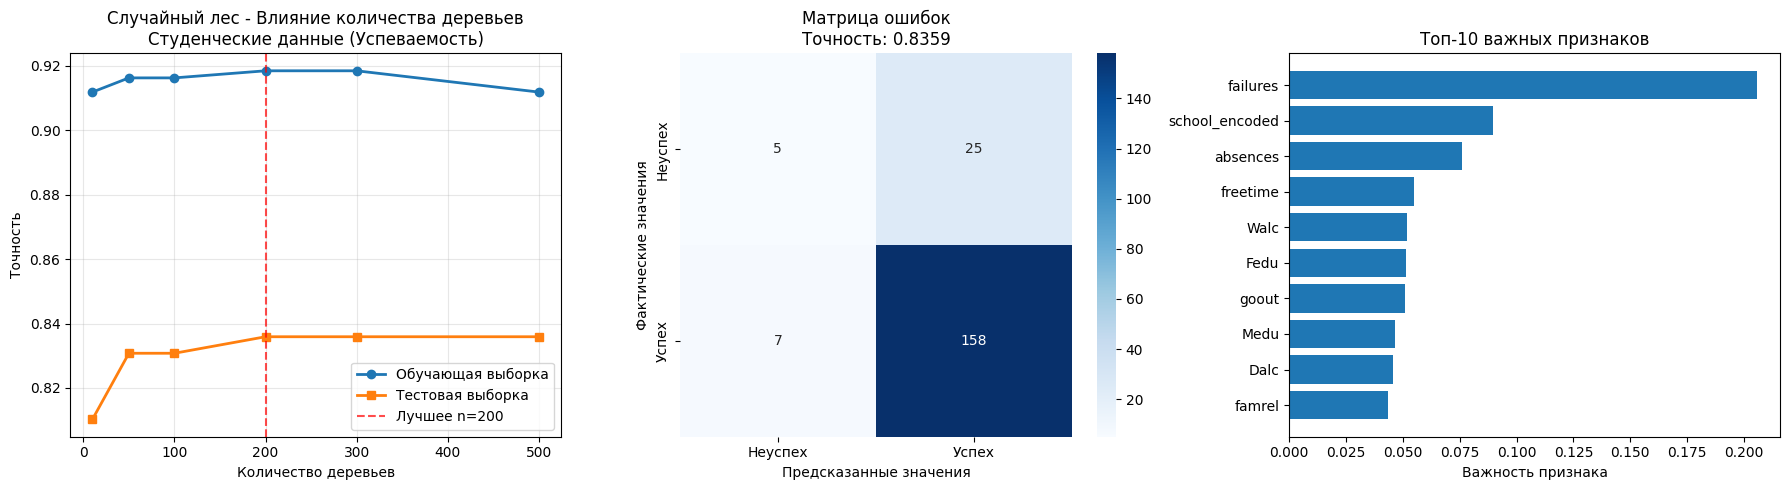


📊 АНАЛИЗ МОДЕЛИ СЛУЧАЙНОГО ЛЕСА:
  Оптимальное количество деревьев: 200
  Точность на тестовой выборке: 0.8359
  Точность на обучающей выборке: 0.9185
  Разница между train и test accuracy: 0.0826
  ✅ Модель хорошо обобщает (малая разница между train и test)

🔝 ТОП-5 ВАЖНЫХ ПРИЗНАКОВ:
  1. failures: 0.2055
  2. school_encoded: 0.0896
  3. absences: 0.0762
  4. freetime: 0.0551
  5. Walc: 0.0517

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
  Precision (Точность): 0.8634
  Recall (Полнота): 0.9576
  F1-Score: 0.9080
  👍 Хорошее качество модели (0.8 ≤ Точность < 0.9)

📋 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:
              precision    recall  f1-score   support

     Неуспех       0.42      0.17      0.24        30
       Успех       0.86      0.96      0.91       165

    accuracy                           0.84       195
   macro avg       0.64      0.56      0.57       195
weighted avg       0.79      0.84      0.80       195



In [18]:
if df_student is not None:
    print("\n" + "🎓 АНАЛИЗ СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ) " + "🎓")
    print("-" * 60)
    
    X_student_class, y_student_class, features_class = preprocess_student_classification(df_student)
    
    if X_student_class is not None:
        knn_class, k_class, score_class = random_forest_classification_study(
            X_student_class, y_student_class, "Студенческие данные (Успеваемость)"
        )
    else:
        print("❌ Не удалось подготовить данные для классификации")

Основной блок выполнения - анализ данных о недвижимости (регрессия)


🏠 АНАЛИЗ ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ) 🏠

ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)
✓ Целевая переменная: Rent (арендная плата)
  Диапазон цен: 1200 - 3500000
✓ Обработана колонка Floor
✓ Обработана колонка Size
✓ Закодирована колонка: Area Type
✓ Закодирована колонка: City
✓ Закодирована колонка: Furnishing Status
✓ Закодирована колонка: Tenant Preferred
✓ Закодирована колонка: Point of Contact
✓ Итоговый набор данных: 4746 samples, 9 features
  Статистика арендной платы: mean=34993.45, std=78106.41

СЛУЧАЙНЫЙ ЛЕС - РЕГРЕССИЯ - Данные о недвижимости (Арендная плата)
🔍 Исследование влияния количества деревьев на R² score...
🎯 Результаты:
  Оптимальное количество деревьев: 500
  Лучший R² score: -0.1416


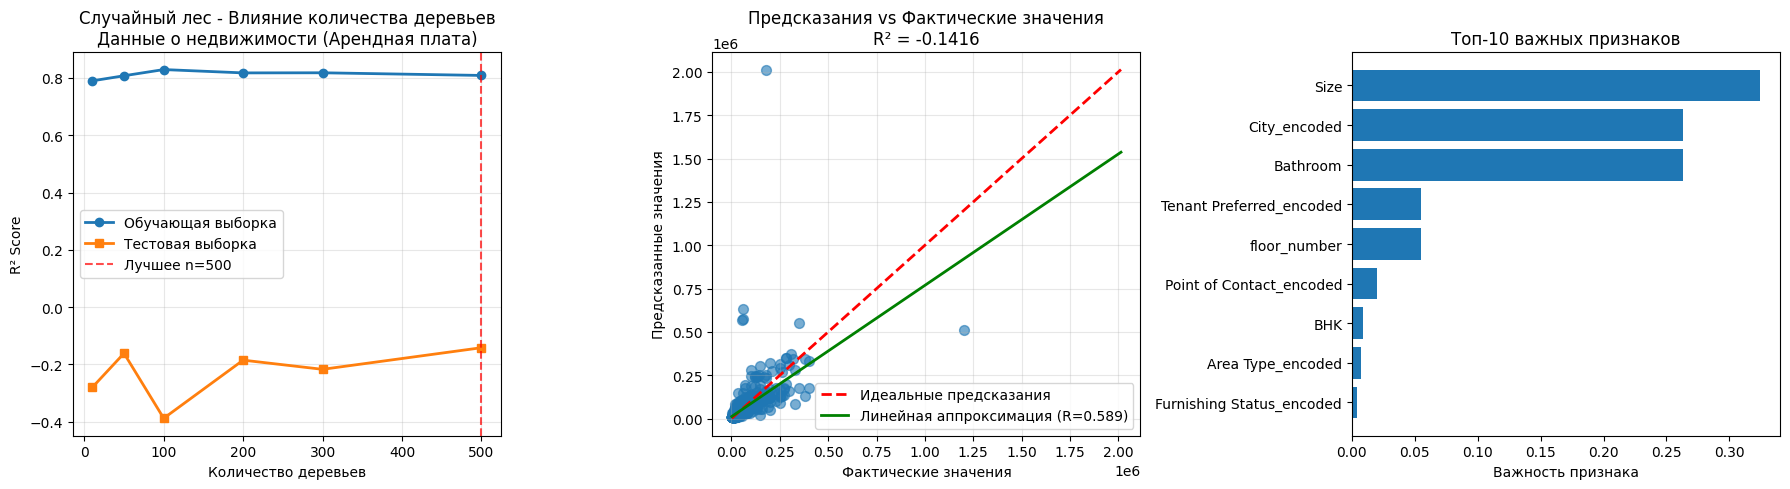


📊 АНАЛИЗ МОДЕЛИ СЛУЧАЙНОГО ЛЕСА:
  Оптимальное количество деревьев: 500
  R² score на тестовой выборке: -0.1416
  R² score на обучающей выборке: 0.8085
  Разница между train и test R²: 0.9502
  ⚠️ Возможное переобучение (большая разница между train и test)

🔝 ТОП-5 ВАЖНЫХ ПРИЗНАКОВ:
  1. Size: 0.3241
  2. City_encoded: 0.2633
  3. Bathroom: 0.2629
  4. Tenant Preferred_encoded: 0.0550
  5. floor_number: 0.0548

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ РЕГРЕССИИ:
  MSE (Mean Squared Error): 4017801717.6643
  RMSE (Root Mean Squared Error): 63386.1319
  MAE (Mean Absolute Error): 15076.6036
  RMSE относительно среднего: 185.04%
  MAE относительно среднего: 44.01%

📊 ОЦЕНКА КАЧЕСТВА МОДЕЛИ ПО R²:
  💡 Низкое качество модели (R² < 0.3)

📊 АНАЛИЗ ОСТАТКОВ:
  Среднее остатков: -2642.6045
  Стандартное отклонение остатков: 63331.0221
  Минимальный остаток: -1833461.5441
  Максимальный остаток: 690445.9782
  ⚠️ Остатки не распределены нормально (тест Шапиро-Уилка, p ≤ 0.05)


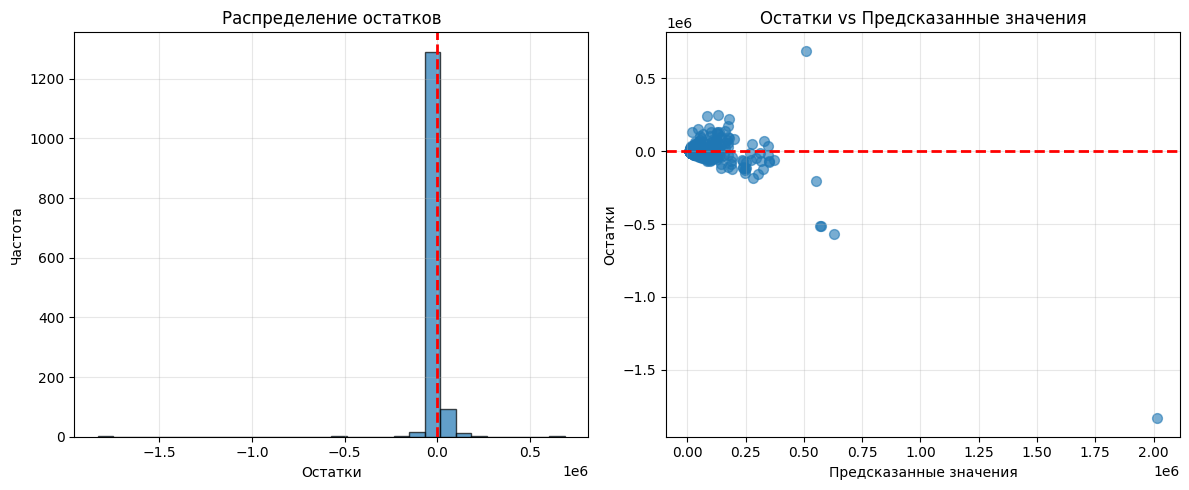

In [19]:
if df_house is not None:
    print("\n" + "🏠 АНАЛИЗ ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ) " + "🏠")
    
    X_house, y_house, features_house = preprocess_house_regression(df_house)
    
    if X_house is not None:
        knn_house, k_house, score_house = random_forest_regression_study(
            X_house, y_house, "Данные о недвижимости (Арендная плата)"
        )
    else:
        print("❌ Не удалось подготовить данные о недвижимости")

Итоги исследования

In [20]:
print("\n" + "="*70)
print("🎯 ИТОГИ ИССЛЕДОВАНИЯ СЛУЧАЙНОГО ЛЕСА")
print("="*70)

print("\n📈 ОСНОВНЫЕ ВЫВОДЫ:")

print("\n🔍 КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:")
print("• Случайный лес эффективен для классификации с четкими границами классов")
print("• Для регрессии с большим разбросом значений (арендная плата) нужна более сложная модель")
print("• Наиболее важные признаки различаются по задачам:")
print("  - Для студентов: академические факторы (провалы, пропуски)")
print("  - Для недвижимости: характеристики жилья (размер, город, ванные)")
print("• Необходимость разных подходов к данным разных типов")

print("\n📊 ОБЩИЙ ВЕРДИКТ:")
print("• Случайный лес - мощный инструмент для задач классификации")
print("• Для регрессии со сложными зависимостями могут потребоваться дополнительные преобразования данных")
print("• Важность признаков помогает в интерпретации моделей")
print("• Необходимо адаптировать подход к специфике данных")


🎯 ИТОГИ ИССЛЕДОВАНИЯ СЛУЧАЙНОГО ЛЕСА

📈 ОСНОВНЫЕ ВЫВОДЫ:

🔍 КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:
• Случайный лес эффективен для классификации с четкими границами классов
• Для регрессии с большим разбросом значений (арендная плата) нужна более сложная модель
• Наиболее важные признаки различаются по задачам:
  - Для студентов: академические факторы (провалы, пропуски)
  - Для недвижимости: характеристики жилья (размер, город, ванные)
• Необходимость разных подходов к данным разных типов

📊 ОБЩИЙ ВЕРДИКТ:
• Случайный лес - мощный инструмент для задач классификации
• Для регрессии со сложными зависимостями могут потребоваться дополнительные преобразования данных
• Важность признаков помогает в интерпретации моделей
• Необходимо адаптировать подход к специфике данных
